# How to use TESSCut in the cloud?

[TESSCut](https://mast.stsci.edu/tesscut/) is an important data access service offered by the TESS data archive at MAST.  TESSCut enables users to request small cutouts from the large collection of TESS Full-Frame Images (FFI). The cutouts are created in the form of Target Pixel Files (TPF) that follow the same format as TESS pipeline files.

The standard TESSCut service can be accessed either via a [web interface](https://mast.stsci.edu/tesscut/) in the browser or via the [astroquery Python package](https://astroquery.readthedocs.io/en/latest/mast/mast.html#tesscut) from a script or notebook.  These interfaces rely on MAST's server to create cutouts and send them back to the user.

While these traditional interfaces to TESSCut will work perfectly fine in the cloud, they are not recommended for very data-intensive projects. Specifically, the MAST servers which power these interfaces do not currently support requesting cutouts for hundreds of objects at the same time, or requesting cutouts for areas larger than 10,000 pixels. Such requests would put an unreasonable load on the servers! The remainder of this notebook explains how this limitation can be resolved by running the code that powers TESSCut in the cloud yourself.

## So, how can I access large numbers of cutouts in the cloud?

The TESSCut service works by extracting data from [pre-generated cubes of TESS pixel data](https://astrocut.readthedocs.io/en/latest/astrocut/index.html#tess-full-frame-image-cutouts). 
These cubes are stored in MAST's public folder on Amazon's cloud object storage service, called [AWS S3](https://aws.amazon.com/s3/), which allows them to be accessed very quickly (e.g., speeds of 10 Gbps or more can be achieved when making requests from virtual servers running in the Amazon cloud).

Specifically, pre-generated data cubes for a given sector, camera, and ccd can be found at the following URI:

    s3://stpubdata/tess/public/mast/tess-s{sector:04d}-{camera}-{ccd}-cube.fits

For example, the data cube containing all pixel flux values for sector 11, camera 4, ccd 1 is located at:

    s3://stpubdata/tess/public/mast/tess-s0011-4-1-cube.fits

Caution: these files are typically very large (>100GB). They are not intended to be downloaded in full.  Instead, MAST has created the [astrocut](https://astrocut.readthedocs.io) Python package which enables users to download the exact parts of the cubes that are required to create a Target Pixel File cutout.

## Example: obtaining TESS cutouts from S3-hosted cubes using `astrocut`

To obtain cutouts from the TESS cube files hosted in AWS S3, you will need to install a special development version of `astrocut` which has been designed to read data from the cloud.  At the time of writing, this package can be installed as follows:

    !pip install git+https://github.com/barentsen/astrocut.git@s3-support

First, we need to define an AstroPy SkyCoord object that defines the location of the cutout:

In [1]:
from astropy.coordinates import SkyCoord
target_crd = SkyCoord.from_name("Pi Men")

We also need to define which astrocut cube we want to extract a cutout from:

In [2]:
cube_file = "s3://stpubdata/tess/public/mast/tess-s0011-4-1-cube.fits"

Then, we can use the astrocut's `CutoutFactory` to create the cutout:

In [3]:
from astrocut import CutoutFactory
factory = CutoutFactory()
factory.cube_cut(cube_file,
                 coordinates=target_crd,
                 cutout_size=11,
                 target_pixel_file="astrocut-result.fits")

'./astrocut-result.fits'

Finally, we can plot or analyze the resulting Target Pixel File using Lightkurve as follows:

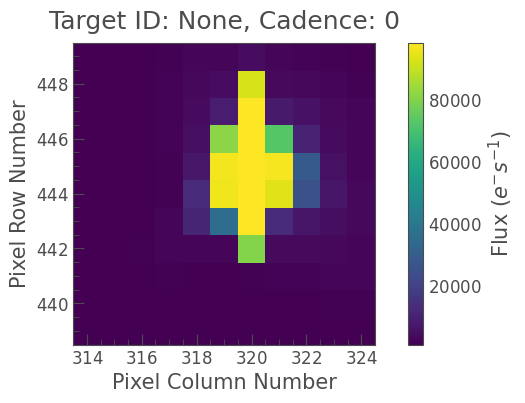

In [4]:
import lightkurve as lk
tpf = lk.read("astrocut-result.fits")
tpf.plot();

Success!

## Why didn't you simply use TESSCut in this example?

Although we could have obtained an identical cutout via the traditional TESSCut interfaces, the method demonstrated here can be used to request much larger numbers of cutouts at the same time. This is because the method demonstrated here reads the required pixel values directly from AWS S3 storage, rather than asking MAST's servers to do this for you. As a result, the number and the size of the cutouts that can be retrieved in this way is only limited by the performance of the server running this Python code, and its bandwidth to transfer data from AWS S3. When running this code in a large virtual machine in the Amazon cloud, e.g. using the TIKE platform, it is likely that hundreds of cutouts can be created in parallel.